# 개요

주제 : 건물 노후 정도에 따른 가스 사고 발생률 분석\
데이터 출처 : 국가공간정보포털, 생활안전정보 (두 데이터 모두 공공데이터포털에서 링크를 타고 본 출처로 가도록 설정되어 있습니다.)\
활용 데이터 : 행정안전부_생활안전지도 노후건물 정보 / 행정안전부_생활안전지도 가스사고발생통계 / 행정안전부_사고안전_정보 / 건축물연령정보 서비스

# 데이터 준비

In [ ]:
# 건축물 연령 속성 조회 인증키
ff16d2ca3883bf51100041
# 가스사고 발생 인증키
IAAEO1QQ-IAAE-IAAE-IAAE-IAAEO1QQTP

필요한 함수 불러오기

In [ ]:
!pip install urllib3
!pip install bs4
!pip install requests

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=32a7ca107ee6c3be8d7d680d1b969cc59e6cad8c8517869bb151d16fbed4b0c6
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


1> 가스사고 발생 통계 (생활안전정보) 불러오기 [API 주소](https://safemap.go.kr/opna/data/dataView.do?objtId=182)

In [ ]:
# 사고 XML
import requests
import urllib.parse

url = "http://safemap.go.kr/openApiService/data/getGasAcdntOccrrncStatsData.do"  # URL
params = {
    "serviceKey": "IAAEO1QQ-IAAE-IAAE-IAAE-IAAEO1QQTP",  # Service Key
    "pageNo": "1",  # 페이지번호
    "numOfRows": "5048",  # 한 페이지 결과 수
    "type": "xml"
}

encoded_params = urllib.parse.urlencode(params)
full_url = url + "?" + encoded_params
print(full_url)
response = requests.get(full_url)

http://safemap.go.kr/openApiService/data/getGasAcdntOccrrncStatsData.do?serviceKey=IAAEO1QQ-IAAE-IAAE-IAAE-IAAEO1QQTP&pageNo=1&numOfRows=5048&type=xml


크롤링한 데이터를 CSV 파일로 저장

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

# XML 데이터 파싱
root = ET.fromstring(response.content)

# XML 데이터를 DataFrame으로 변환
data = []
for item in root.iter('item'):
    row = {}
    for child in item:
        row[child.tag] = child.text
    data.append(row)
df = pd.DataFrame(data)

# DataFrame을 CSV 파일로 저장
df.to_csv("accident.csv", index=False)

In [ ]:
from google.colab import files
files.download("accident.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2> 건축물 연령 속성 조회 (국가공간정보포털) 불러오기
[API 주소](http://openapi.nsdi.go.kr/nsdi/eios/ServiceDetail.do?svcSe=S&svcId=S028)

In [ ]:
# 건축물 연령
import requests
import urllib.parse

url = "http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge"  # URL
params = {
    "authkey": "ff16d2ca3883bf51100041",  # Service Key
    "pnu": "11110183",  # 건물고유번호 (8자리 이상 기입)
    #"buldAge": "6",  # 건물연령
    #"buldAgeSe" : "1"
    "format": "xml",
    "numOfRows": "10000",
    #"pageNo": "1"
}

encoded_params = urllib.parse.urlencode(params)
full_url = url + "?" + encoded_params
print(full_url)
response1 = requests.get(full_url)

http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge?authkey=ff16d2ca3883bf51100041&pnu=11110183&format=xml&numOfRows=10000


크롤링한 데이터를 CSV 파일로 저장

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

# XML 파싱
root = ET.fromstring(response1.content)

# 데이터를 저장할 빈 리스트 생성
data = []

# XML 데이터에서 필요한 정보 추출
for item in root.iter('field'):
    row = {}
    for child in item:
        row[child.tag] = child.text
    data.append(row)

# DataFrame 생성
df = pd.DataFrame(data)

# CSV 파일로 저장
df.to_csv('buildingage.csv', index=False)

In [ ]:
from google.colab import files
files.download("buildingage.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3> 지역 발전 현황 (국가지도집 1권)(2019) : <1>과 <2>를 통해 수집한 자료를 비교할 원본 데이터 \
[국가 지도집](http://nationalatlas.ngii.go.kr/pages/page_1866.php#prettyPhoto)

# 데이터 전처리

### 1> 가스사고 발생 통계 데이터 전처리

In [ ]:
import pandas as pd
from xml.etree import ElementTree as ET

if response.status_code == 200:
    root = ET.fromstring(response.content)

    emd_codes = [element.text for element in root.findall(".//EMD_CD")]
    x_values = [element.text for element in root.findall(".//X")]
    y_values = [element.text for element in root.findall(".//Y")]
    total_accidents = [element.text for element in root.findall(".//TOT")]
    ctprvn_names = [element.text for element in root.findall(".//CTPRVN_NM")]
    sgg_names = [element.text for element in root.findall(".//SGG_NM")]
    emd_names = [element.text for element in root.findall(".//EMD_NM")]

    valid_emd_codes = []
    valid_x_values = []
    valid_y_values = []
    valid_total_accidents = []
    valid_ctprvn_names = []
    valid_sgg_names = []
    valid_emd_names = []

# 전체 데이터 셋에서 사고 수가 0건인 지역의 데이터 제거
    for i in range(len(emd_codes)):
        if total_accidents[i] != '0':
            valid_emd_codes.append(emd_codes[i])
            valid_x_values.append(x_values[i])
            valid_y_values.append(y_values[i])
            valid_total_accidents.append(total_accidents[i])
            valid_ctprvn_names.append(ctprvn_names[i])
            valid_sgg_names.append(sgg_names[i])
            valid_emd_names.append(emd_names[i])

# 필요한 데이터인 시구동 명과 시도코드, XY좌표, 전체 사고 발생 건수만 불러오기
    data = {
        'CTPRVN_NM': valid_ctprvn_names,
        'SGG_NM': valid_sgg_names,
        'EMD_NM': valid_emd_names,
        'EMD_CD': valid_emd_codes,
        'X': valid_x_values,
        'Y': valid_y_values,
        'TOT': valid_total_accidents
    }

    df = pd.DataFrame(data)
    print(df)

else:
    print("Error accessing the URL:", response.status_code)

print(f'전체 사고 발생 건 수 >> {len(df)}')

    CTPRVN_NM SGG_NM EMD_NM    EMD_CD            X            Y TOT
0       서울특별시     중구   명동2가  11140127  14135726.88  4517813.841   1
1       서울특별시    성동구  하왕십리동  11200102  14140414.65  4517485.561   1
2       서울특별시    광진구    중곡동  11215101  14147462.71  4517951.853   1
3       서울특별시    광진구    군자동  11215109  14145754.57  4516488.404   1
4       서울특별시   동대문구    용두동  11230102  14141392.77  4519661.545   1
..        ...    ...    ...       ...          ...          ...  ..
290   제주특별자치도    제주시    추자면  50110320  14061099.96  4021919.948   1
291   제주특별자치도   서귀포시    서귀동  50130101   14088462.5  3928400.009   1
292   제주특별자치도   서귀포시    법환동  50130102  14083299.34  3927575.082   2
293   제주특별자치도   서귀포시    성산읍  50130259  14122654.56  3950980.709   1
294   제주특별자치도   서귀포시    표선면  50130320  14109901.52    3946017.6   2

[295 rows x 7 columns]
전체 사고 발생 건 수 >> 295


In [ ]:
# csv 파일로 저장 (전처리한 데이터)
df.to_csv("accident_clean.csv", index=False)

In [ ]:
from google.colab import files
files.download("accident_clean.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2> 건축물 연령 통계 전처리

가스 사고가 발생한 곳의 건축물 연령 출력

In [ ]:
# pass emd code as argument: return mean age of bulidings in area
import pandas as pd
from xml.etree import ElementTree as ET
def meanAgeBuilding(emd_code):
    url = "http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge"  # URL
    params = {
    "authkey": "ff16d2ca3883bf51100041",  # Service Key
    "pnu": emd_code,  # 건물고유번호 (8자리 이상 기입)
    "format": "xml",
    "numOfRows": "10000",
    }

    encoded_params = urllib.parse.urlencode(params)
    full_url = url + "?" + encoded_params
    print(full_url)
    response = requests.get(full_url)
    root = ET.fromstring(response.content)
    buildingAge = [element.text for element in root.findall(".//buldAge")]
    buildingAgeSum = 0
    for i in buildingAge:
        buildingAgeSum = buildingAgeSum + int(i)
    try:
        meanAge = float(buildingAgeSum) / len(buildingAge)
        print(meanAge)
        return meanAge
    except ZeroDivisionError:
        continue

In [ ]:
# retrieve mean age for all area accidents
valid_buildingAge = []
for code in valid_emd_codes:
    age = meanAgeBuilding(code)
    if age is not None:
        valid_buildingAge.append(age)

CSV 파일로 저장
: 코랩 상에서 가동되는데 너무 오랜 시간이 걸려서 따로 python 파일을 작성하였습니다. 추후 메일로 따로 첨부하겠습니다.

모집단 비교를 위해 랜덤으로 시도 코드를 생성하여 평균 건물 연령 측정

In [ ]:
import random

def generate_random_emd_codes(num_codes):
    emd_codes = []
    for _ in range(num_codes):
        # 2자리 시도 코드 생성 (01부터 36까지)
        sido_code = str(random.randint(1, 36)).zfill(2)
        # 3자리 시군구 코드 생성 (001부터 150까지)
        sigungu_code = str(random.randint(1, 150)).zfill(3)
        # 3자리 읍면동 코드 생성 (001부터 999까지)
        eupmyeondong_code = str(random.randint(1, 999)).zfill(3)
        # 8자리로 조합하여 PNU 생성
        emd_code = sido_code + sigungu_code + eupmyeondong_code
        emd_codes.append(emd_code)

    return emd_codes

# 10개의 랜덤 시도 코드 생성
random_emd_codes = generate_random_emd_codes(10)

# meanAgeBuilding 함수 호출 및 건물 평균 연령 확인
for emd_code in random_emd_codes:
    try:
        building_age = meanAgeBuilding(emd_code)
        print(f"지역 코드: {emd_code}, 건물 평균 연령: {building_age}")
    except Exception as e:
        print(f"지역 코드: {emd_code}, 유효한 코드가 아닙니다.")

http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge?authkey=ff16d2ca3883bf51100041&pnu=21112237&format=xml&numOfRows=10000
No building data available for this area.
지역 코드: 21112237, 건물 평균 연령: None
http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge?authkey=ff16d2ca3883bf51100041&pnu=12139940&format=xml&numOfRows=10000
No building data available for this area.
지역 코드: 12139940, 건물 평균 연령: None
http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge?authkey=ff16d2ca3883bf51100041&pnu=06066874&format=xml&numOfRows=10000
No building data available for this area.
지역 코드: 06066874, 건물 평균 연령: None
http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge?authkey=ff16d2ca3883bf51100041&pnu=36117420&format=xml&numOfRows=10000
No building data available for this area.
지역 코드: 36117420, 건물 평균 연령: None
http://openapi.nsdi.go.kr/nsdi/BuildingAgeService/attr/getBuildingAge?authkey=ff16d2ca3883bf51100041&pnu=12048552&format=xml&numOfRows=10000

완벽한 모평균 비교를 하고자 랜덤으로 지역 코드를 설정해주었으나 지역 코드를 만드는것에 다른 조건이 부여되는 것으로 관찰되었으나 그 조건이 일정한 규칙을 가지지 않고, 직접 설정해줄 필요가 있었다. 수동 설정을 통한 데이터 오염을 방지하고자 모평균 비교를 진행하지 않았다.

# 데이터 시각화

### 1> 가스사고 발생 통계 자료 시각화

In [ ]:
!pip install matplotlib

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (20.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and direc

**1> 각 광역자치단체 별 가스사고 발생량 (막대그래프)**

각 광역자치단체의 상징색은 홈페이지에 명시된 상징색을 따름 \
[광역자치단체 대표 색상](https://namu.wiki/w/%EA%B4%91%EC%97%AD%EC%9E%90%EC%B9%98%EB%8B%A8%EC%B2%B4)

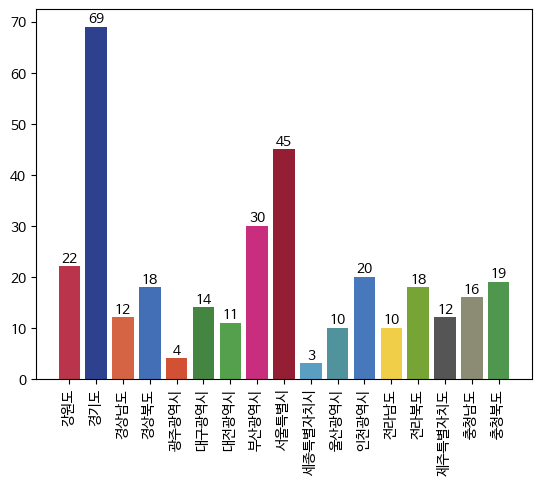

In [ ]:
import matplotlib.pyplot as plt

# 각 광역자치단체의 상징색 (RGB 코드)
# df.sample() 을 통해 자료 상 광역자치단체의 표시명 확인 후 적용
colors = {
    '서울특별시': '#941e34',
    '부산광역시': '#C82E7D',
    '대구광역시': '#458542',
    '인천광역시': '#4778BB',
    '광주광역시': '#D25033',
    '대전광역시': '#54A04C',
    '울산광역시': '#51939C',
    '세종특별자치시': '#5A9EC2',
    '경기도': '#2E418E',
    '강원도': '#BA354B',
    '충청북도': '#4F974E',
    '충청남도': '#8B8C73',
    '전라북도': '#77A535',
    '전라남도': '#F1CE48',
    '경상북도': '#426FB5',
    '경상남도': '#D56445',
    '제주특별자치도': '#555555'
}

df = pd.read_csv('accident_clean.csv', encoding='utf-8')

# 'CTPRVN_NM'을 기준으로 사고 건수 합계 계산
df['TOT'] = df['TOT'].astype(int)
grouped = df.groupby('CTPRVN_NM')['TOT'].sum()

# 막대그래프 그리기
plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots()
bars = ax.bar(grouped.index, grouped.values, color=[colors[name] for name in grouped.index])

# 각 막대에 대한 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.xticks(rotation=90)  # x축 레이블 회전 (세로로 표시)
plt.show()

**2> 지도에 표기**

생활안전정보 포털에서 제공하는 위치 정보인 X값과 Y값은 기존에 사용하는 WSG84의 위도 경도 표기 방식이 아닌 새로운 표기 방식이었습니다. \
여러 좌표계를 찾아보다 ESPG097 좌표계를 사용한 다는 것까지 유추하였으나 이 좌표계를 지도에 나타낼 수 있는 위도 경도 시스템으로 바꾸는 식을 알아내지 못해 지도 구현에 실패하였습니다. \
다음에 기회가 된다면 좌표계를 공부해 시도해 보겠습니다.

In [ ]:
!pip install folium
import folium

In [ ]:
# 필요한 라이브러리 import
import pandas as pd
import folium
import json

# 데이터 로딩
df = pd.read_csv('accident_clean.csv')

# 시도 경계선 정보 불러오기
with open('mapsample.json', 'r', encoding='utf-8') as f:
    geo_data = json.load(f)

# 지도 초기화 (중심 좌표는 서울로 설정)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=7)

# Choropleth 맵 추가
folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=df,
    columns=['CTPRVN_NM', 'TOT'],
    key_on='feature.properties.CTPRVN_NM',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Accident Count'
).add_to(m)

# 지도 표시
m

AttributeError: ignored

그 대신, X라벨과 Y라벨의 figsize를 조정해 기존 데이터를 활용해서 대한민국 지도처럼 보이도록 수정해보았습니다.

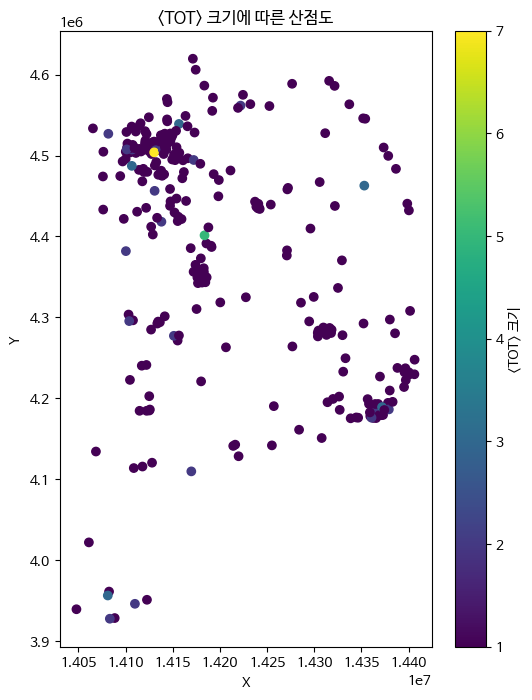

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 데이터 파일 읽기
df = pd.read_csv('accident_clean.csv')

# 필요한 열 추출
X = df['X']
Y = df['Y']
TOT = df['TOT']

# 색상 설정
#norm = plt.Normalize(TOT.min(), TOT.max())
#colors = cm.Reds(norm(TOT))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6,8))
scatter = ax.scatter(X, Y, c=TOT, cmap='viridis')

# 컬러바 설정
cbar = plt.colorbar(scatter)
cbar.set_label('<TOT> 크기')

# 그래프 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('<TOT> 크기에 따른 산점도')

# 그래프 출력
plt.show()

### 2> 건축물 연령 통계 자료 시각화

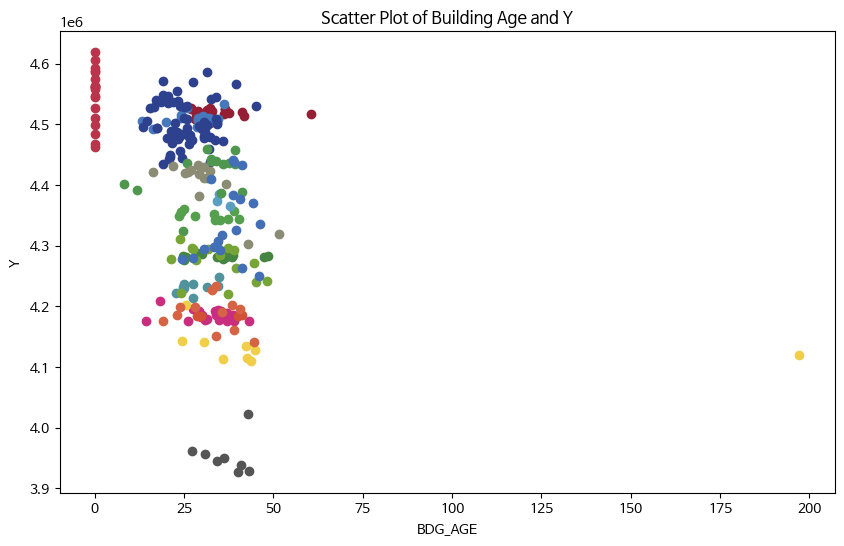

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# buildingage_clean.csv 파일 읽기
df = pd.read_csv('/buildingage_cl.csv', encoding='cp949')

# 색상 지정
colors = {
    '서울특별시': '#941e34',
    '부산광역시': '#C82E7D',
    '대구광역시': '#458542',
    '인천광역시': '#4778BB',
    '광주광역시': '#D25033',
    '대전광역시': '#54A04C',
    '울산광역시': '#51939C',
    '세종특별자치시': '#5A9EC2',
    '경기도': '#2E418E',
    '강원도': '#BA354B',
    '충청북도': '#4F974E',
    '충청남도': '#8B8C73',
    '전라북도': '#77A535',
    '전라남도': '#F1CE48',
    '경상북도': '#426FB5',
    '경상남도': '#D56445',
    '제주특별자치도': '#555555'
}

# 그래프 그리기
plt.figure(figsize=(10, 6))
for idx, row in df.iterrows():
    plt.scatter(row['BDG_AGE'], row['Y'], color=colors.get(row['CTPRVN_NM'], 'gray'))
plt.xlabel('BDG_AGE')
plt.ylabel('Y')
plt.title('Scatter Plot of Building Age and Y')
plt.show()

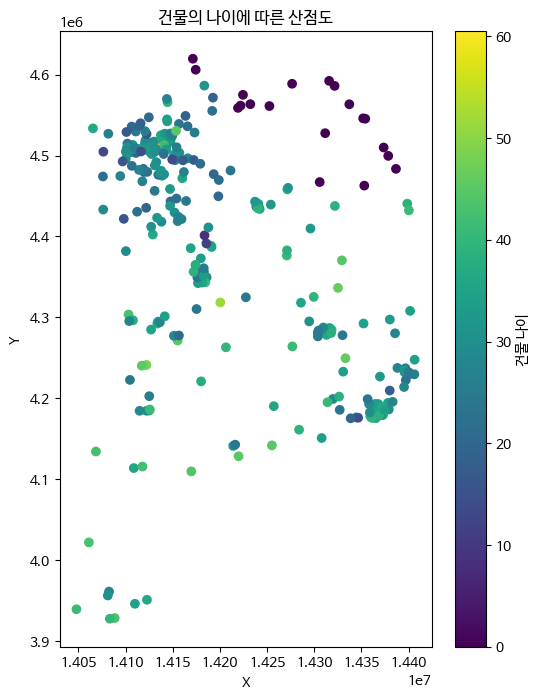

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 데이터 파일 읽기
df = pd.read_csv('/buildingage_cl.csv', encoding='cp949')

# X, Y, BDG_AGE 열 추출
X = df['X']
Y = df['Y']
BDG_AGE = df['BDG_AGE']

# 색상 설정
#norm = plt.Normalize(BDG_AGE.min(), BDG_AGE.max())
#colors = cm.Reds(norm(BDG_AGE))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 8))
scatter = ax.scatter(X, Y, c=BDG_AGE, cmap='viridis')

# 컬러바 설정
cbar = plt.colorbar(scatter)
cbar.set_label('건물 나이')

# 그래프 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('건물의 나이에 따른 산점도')

# 그래프 출력
plt.show()